# Claasification — CLIP
**Author:** Sayed Pedram Haeri Boroujeni  
**Position:** PhD Student, Clemson University  
**Affiliation:** Department of Computer Science  
**Email:** shaerib@g.clemson.edu  
**Date Created:** October 10, 2025  

##### 1. Importing Required Libraries

In [1]:
import os
import torch
import clip                    
from PIL import Image
from PIL import UnidentifiedImageError
import argparse, os, random, time, math
from pathlib import Path
import numpy as np
import torch.backends.cudnn as cudnn
from torchvision import transforms
from tqdm import tqdm           
import numpy as np
import seaborn as sns   
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

##### 2. Checking GPU Availability

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Device Name: {torch.cuda.get_device_name()}")
else:
    print("CUDA is not available on this system.")

CUDA Available: True
CUDA Version: 12.6
Number of GPUs: 1
Device Name: NVIDIA RTX A5000


##### 3. Reproducibility

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

set_seed(5)

##### 4. Configuration

In [4]:
# Base dataset directory
data_dir = r"C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/Fire"
splits = ["train", "val", "test"]      # If any split folder missing, code will skip it automatically
classes = ["fire", "no_fire"]

# CLIP Model Parameters
config = {
    "input_size": "224×224",
    "input_channels": "RGB",
    "tokens": 77,
    "batch_size": 32,
    "similarity_metric": "Cosine",
    "backbone": "ViT-L/14",
    "embedding_dim": 768,
    "preprocessing": "Normalization",
    "augmentation": "Random Crop-Flip",
}

# Load CLIP model and device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model, preprocess = clip.load(config["backbone"], device=device)
model.eval()

# Display Configuration Summary
print("\n CLIP Configuration Summary")
for key, val in config.items():
    print(f"{key:<18}: {val}")

Using device: cuda

 CLIP Configuration Summary
input_size        : 224×224
input_channels    : RGB
tokens            : 77
batch_size        : 32
similarity_metric : Cosine
backbone          : ViT-L/14
embedding_dim     : 768
preprocessing     : Normalization
augmentation      : Random Crop-Flip


##### 5. Dataset Preparation

In [5]:
print(f"\n📁 Base Dataset Directory: {data_dir}\n")

def count_images_in_folder(folder_path):
    """Count number of image files (jpg/png/jpeg) in a folder."""
    exts = {".jpg", ".jpeg", ".png"}
    return sum(1 for f in os.listdir(folder_path)
               if os.path.splitext(f)[1].lower() in exts)

# Walk through each split and class
for split in splits:
    split_path = os.path.join(data_dir, split)
    if not os.path.exists(split_path):
        print(f"  ⚠️ Split '{split}' not found, skipping.")
        continue
    print(f"📂 {split}/")
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        if os.path.exists(cls_path):
            n_imgs = count_images_in_folder(cls_path)
            print(f"    ├── {cls}/  ({n_imgs} images)")
        else:
            print(f"    ├── {cls}/  (folder missing)")


📁 Base Dataset Directory: C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/Fire

📂 train/
    ├── fire/  (453 images)
    ├── no_fire/  (146 images)
📂 val/
    ├── fire/  (151 images)
    ├── no_fire/  (49 images)
📂 test/
    ├── fire/  (151 images)
    ├── no_fire/  (49 images)


##### 6. CLIP Testing

✅ Found 200 test images.


Evaluating: 100%|█████████████████████████████| 200/200 [00:19<00:00, 10.19it/s]



📊 Evaluation Results (Zero-Shot CLIP)
Accuracy : 94.50%
Precision: 88.00%
Recall   : 89.80%
F1-score : 88.89%


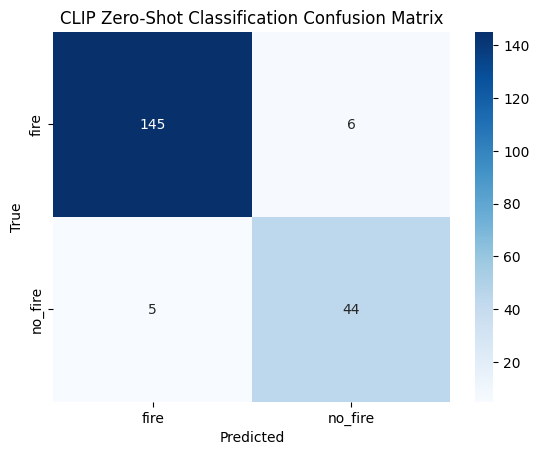

In [6]:
text_prompts = ["a photo of fire", "a photo of no fire"]
text_tokens = clip.tokenize(text_prompts).to(device)

# Collect test image paths 
test_dir = os.path.join(data_dir, "test")
image_paths, labels = [], []

for label_idx, cls in enumerate(classes):
    cls_path = os.path.join(test_dir, cls)
    if not os.path.exists(cls_path):
        print(f" Missing folder: {cls_path}")
        continue
    for f in os.listdir(cls_path):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(cls_path, f))
            labels.append(label_idx)

print(f"✅ Found {len(image_paths)} test images.")

# Evaluation
preds = []
model.eval()

for path in tqdm(image_paths, desc="Evaluating", ncols=80):
    try:
        image = preprocess(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text_tokens)
            logits_per_image, _ = model(image, text_tokens)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]
            preds.append(np.argmax(probs))
    except (UnidentifiedImageError, OSError):
        print(f" Skipped unreadable image: {path}")
        preds.append(-1)  # mark as invalid

# Remove any invalid images
valid_indices = [i for i, p in enumerate(preds) if p != -1]
y_true = np.array([labels[i] for i in valid_indices])
y_pred = np.array([preds[i] for i in valid_indices])

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n📊 Evaluation Results (Zero-Shot CLIP)")
print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall   : {rec*100:.2f}%")
print(f"F1-score : {f1*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CLIP Zero-Shot Classification Confusion Matrix")
plt.show()

##### 7. Output Sampels

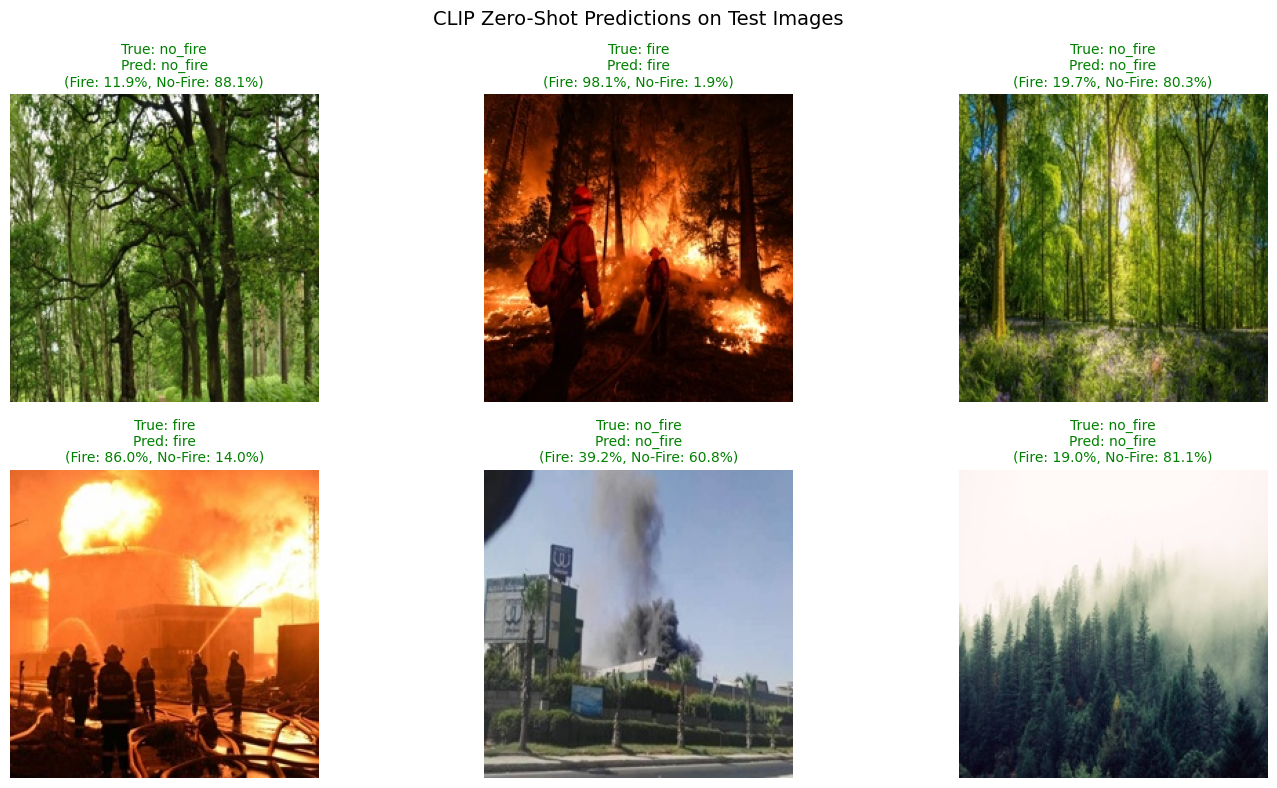

In [7]:
num_samples = min(6, len(valid_indices))
sample_indices = random.sample(valid_indices, num_samples)

plt.figure(figsize=(15, 8))

for i, idx in enumerate(sample_indices):
    path = image_paths[idx]
    true_label = classes[labels[idx]]
    
    # Re-run CLIP to get prediction and probabilities
    image = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        logits_per_image, _ = model(image, text_tokens)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]
        pred_idx = np.argmax(probs)
        pred_label = classes[pred_idx]
    
    plt.subplot(2, 3, i + 1)
    img = Image.open(path).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"True: {true_label}\nPred: {pred_label}\n"
        f"(Fire: {probs[0]*100:.1f}%, No-Fire: {probs[1]*100:.1f}%)",
        fontsize=10,
        color=("green" if true_label == pred_label else "red"),
    )

plt.suptitle("CLIP Zero-Shot Predictions on Test Images", fontsize=14)
plt.tight_layout()
plt.show()

##### 12. Cross-Dataset Evaluation

In [9]:
base_path = r"C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset"
test_datasets = {
    "FLAME1":        False,
    "FLAME2":        False,
    "FLAME3":        False,
    "DeepFire":      False,
    "D-Cluster":     False,
    "FF-Det":        False,
    "Fire":          True,
    "Wildfire-Det":  False,
    "BoWFire":       False,
    "D-Fire":        False,
    "FiSmo":         False,
}

text_prompts = ["a photo of fire", "a photo of no fire"]
text_tokens = clip.tokenize(text_prompts).to(device)

def eval_clip_dataset(model, dataset_dir, text_tokens, classes):
    test_dir = Path(dataset_dir) / "test"
    if not test_dir.exists():
        print(f" Skipping {dataset_dir} — no test folder found.")
        return None

    image_paths, labels = [], []
    for i, cls in enumerate(classes):
        cls_dir = test_dir / cls
        if cls_dir.exists():
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_paths.append(cls_dir / f)
                    labels.append(i)
    if not image_paths:
        print(f" No images found in {dataset_dir}")
        return None

    preds = []
    model.eval()
    for path in tqdm(image_paths, desc=f"{Path(dataset_dir).name}", ncols=70):
        try:
            img = preprocess(Image.open(path)).unsqueeze(0).to(device)
            with torch.no_grad():
                logits, _ = model(img, text_tokens)
                probs = logits.softmax(dim=-1).cpu().numpy()[0]
                preds.append(np.argmax(probs))
        except Exception:
            preds.append(-1)

    valid = [i for i, p in enumerate(preds) if p != -1]
    y_true = np.array([labels[i] for i in valid])
    y_pred = np.array([preds[i] for i in valid])

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

print("\n Cross-Dataset CLIP Evaluation\n")
results = {}

for name, active in test_datasets.items():
    if not active: 
        continue
    dataset_path = Path(base_path) / name
    if not dataset_path.exists():
        print(f"❌ Missing dataset: {dataset_path}")
        continue

    m = eval_clip_dataset(model, dataset_path, text_tokens, classes)
    if m:
        results[name] = m
        print(f"\n📊 {name} Results:")
        for k, v in m.items():
            print(f"  {k:<10}: {v*100:.2f}%")

if results:
    print("\n Summary Across Datasets:")
    for name, m in results.items():
        print(f"{name:<15} | Acc: {m['Accuracy']*100:.2f}% | "
              f"Prec: {m['Precision']*100:.2f}% | Rec: {m['Recall']*100:.2f}% | "
              f"F1: {m['F1']*100:.2f}%")
else:
    print(" No datasets evaluated — enable at least one in test_datasets.")



 Cross-Dataset CLIP Evaluation



Fire: 100%|█████████████████████████| 200/200 [00:10<00:00, 19.62it/s]


📊 Fire Results:
  Accuracy  : 94.50%
  Precision : 88.00%
  Recall    : 89.80%
  F1        : 88.89%

 Summary Across Datasets:
Fire            | Acc: 94.50% | Prec: 88.00% | Rec: 89.80% | F1: 88.89%
